### Last updated May 2023

In [30]:
import os
os.chdir('/Users/haozheshan/Dropbox/codes/gp_continual_learning/')
import numpy as np
import matplotlib.pyplot as plt
import theory, cluster_utils, torch, data, utils, tqdm, scipy.optimize

%load_ext autoreload
%autoreload 2

# USE KEYWORDS BELOW TO SEARCH FOR FOLDERS
batch_name_list =cluster_utils.list_folders('cluster_results/', '', 'toy', 'diff_strength')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generating a list at 2023-05-27 21:53
[0] gp_toy_30x50_xsim80_1L_10context_diff_strength
[1] gp_toy_30x50_xsim90_1L_50context_diff_strength
[2] gp_toy_30x50_xsim60_1L_50context_diff_strength
[3] gp_toy_30x50_xsim30_1L_50context_diff_strength
[4] gp_toy_30x50_xsim80_1L_50context_diff_strength
[5] gp_toy_30x50_xsim60_1L_10context_diff_strength
[6] gp_toy_30x50_xsim0_1L_50context_diff_strength


No key was specified. Automatically using key <<context_strength>> to sort the results.
"NSEEDS" found in the arguments. Assuming that each file contains multiple random seeds.
=================== Cluster organizer ===================
21 data objects loaded from folder "gp_toy_30x50_xsim80_1L_50context_diff_strength".
For key <<context_strength>>, the values are [450.0, 275.0, 175.0, 250.0, 150.0, 475.0, 100.0, 300.0, 125.0, 325.0, 0.0, 400.0, 500.0, 225.0, 200.0, 25.0, 425.0, 375.0, 75.0, 350.0, 50.0]
=================== Cluster organizer ===================
Available data keys are dict_keys(['args', 'train loss', 'test loss', 'train acc', 'test acc', 'train loss naive', 'test loss naive', 'train acc naive', 'test acc naive', 'train magnitude', 'train magnitude naive', 'tr(P1P2)/P', 'V1-V2', 'M tau', 'A tau', 'M asym', 'A asym'])
Namespace(f=None, cluster=0, BATCH_NAME='gp_toy_30x50_xsim80_1L_50context_diff_strength', TRIAL_IND=2, P=50, P_test=100, n_tasks=30, T=0.0, sigma=0.2, N0=100

IndexError: index 6 is out of bounds for axis 0 with size 6

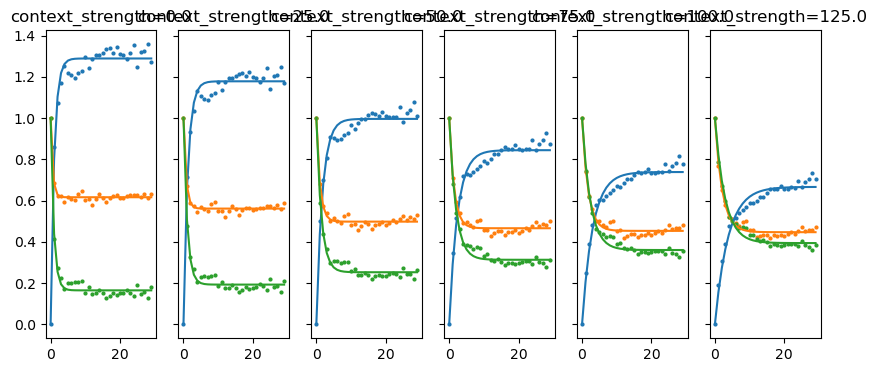

In [31]:
folder_index = 4
organizer = cluster_utils.ClusterResultOrganizer('cluster_results/', batch_name=batch_name_list[folder_index])

num_keys, te_acc_arr = organizer.organize_results('test acc', as_arrays=True)
num_keys, tr_acc_arr = organizer.organize_results('train acc', as_arrays=True)
num_keys, te_loss_arr = organizer.organize_results('test loss', as_arrays=True)
num_keys, tr_loss_arr = organizer.organize_results('train loss', as_arrays=True)
# num_keys, all_nn_preds = organizer.organize_results('sampled outputs', as_arrays=True)
num_keys, tr_mag_arr = organizer.organize_results('train magnitude', as_arrays=True)
num_keys, trp1p2_arr = organizer.organize_results('tr(P1P2)/P', as_arrays=True)
# num_keys, all_v1_v2 = organizer.organize_results('V1-V2', as_arrays=True)

args = organizer.args
print(args)

def fit_loss_curves(all_train_loss, all_train_mag):
    all_L = all_train_loss.mean(1)[:, 0, :]
    all_M = all_train_mag.mean(1)[:, 0, :]
    all_A = -0.5 * (all_L - all_M - 1)

    a_taus = []
    a_asyms = []
    m_taus = []
    m_asyms = []
    for m in all_M:
        m_asym, m_tau, _ = utils.exponential_fit(np.arange(len(m)), m)
        m_taus.append(m_tau)
        m_asyms.append(m_asym)
    
    for a in all_A:
        a_asym, a_tau, _ = utils.exponential_fit(np.arange(len(a)), a)
        a_taus.append(a_tau)
        a_asyms.append(a_asym)
    
    return np.array(a_taus), np.array(a_asyms), np.array(m_taus), np.array(m_asyms)

# a_taus, a_asyms, m_taus, m_asyms = fit_loss_curves(all_train_loss, all_train_mag)


fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(10, 4), sharex=True, sharey=True)
axes = axes.ravel()

m_tau_fitted = organizer.organize_results('M tau')

for i in range(len(num_keys)):
    plt.sca(axes[i])
    L = tr_loss_arr[i].mean(0)[0]
    M = tr_mag_arr[i].mean(0)[0]
    A = (L - 1 - M) * -0.5
    _ = utils.plot_and_exp_fit(L, label='loss', r_and_gain=False)
    _ = utils.plot_and_exp_fit(M, label='Mag', r_and_gain=False)
    _ = utils.plot_and_exp_fit(A, label='Align', r_and_gain=False)
    plt.title(f'{organizer.sort_by_key}={num_keys[i]}')
    
    # plt.xlabel('age of task 1')
# plt.legend(['L', None, 'M', None, 'A', None])
plt.sca(axes[0])
plt.legend()
plt.suptitle(f'{batch_name_list[folder_index]}')
plt.tight_layout()


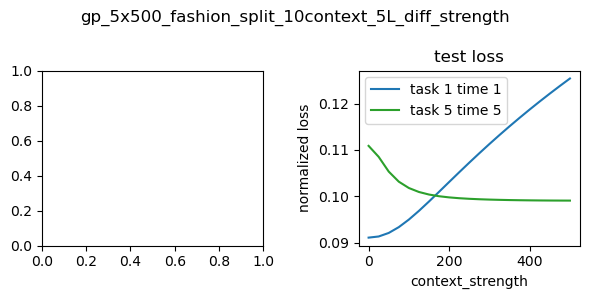

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=False)
axes.ravel()

# plt.sca(axes[0])
# plt.plot(num_keys, tr_loss_arr.mean(1)[:, 0, 0], label='task 1 time 1')
# # plt.plot(num_keys, tr_loss_arr.mean(1)[:, 0, 4], label='task 1 time 5')
# plt.plot(num_keys, tr_loss_arr.mean(1)[:, 4, 4], label='task 5 time 5')
# plt.xlabel(organizer.sort_by_key)
# plt.legend()
# plt.ylabel('normalized loss')
# plt.title('train loss')


plt.sca(axes[1])
plt.plot(num_keys, te_loss_arr.mean(1)[:, 0, 0], label='task 1 time 1', color='C0')
# plt.plot(num_keys, te_loss_arr.mean(1)[:, 0, 4], label='task 1 time 5')
plt.plot(num_keys, te_loss_arr.mean(1)[:, 4, 4], label='task 5 time 5', color='C2')
plt.xlabel(organizer.sort_by_key)
plt.legend()
plt.ylabel('normalized loss')
plt.title('test loss')

plt.suptitle(batch_name_list[folder_index])
plt.tight_layout()

Text(0.5, 1.0, 'gp_5x500_cifar_split_10context_diff_strength')

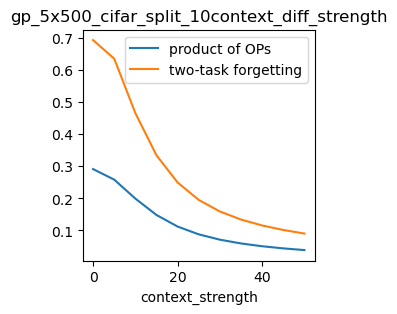

In [53]:
plt.figure(figsize=(3, 3))
plt.plot(num_keys, all_trp1p2[:].mean(1) * 2, label='product of OPs')
plt.plot(num_keys, all_train_loss[:, :, 0, 1].mean(1), label='two-task forgetting')
plt.xlabel(organizer.sort_by_key)
plt.legend()
plt.title(batch_name_list[folder_index])


# plt.plot(all_trp1p2[:].mean(1), np.exp(-1/a_taus), marker='o')

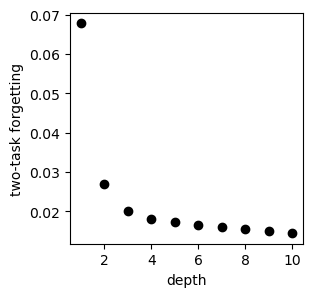

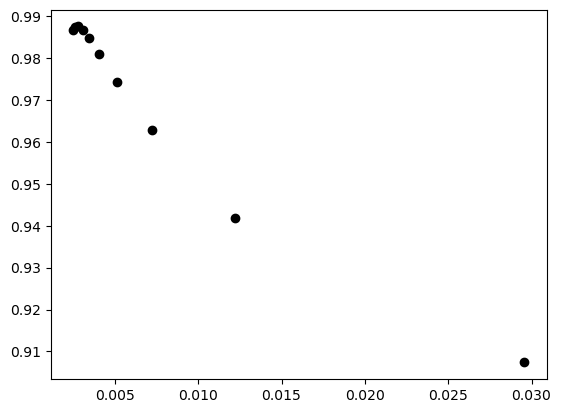

In [22]:
plt.figure(figsize=(3, 3))
for i in range(len(num_keys)):
    plt.scatter(num_keys[i], all_train_loss[i].mean(0)[0, 1], color='k')
    
plt.xlabel('depth')
plt.ylabel('two-task forgetting')

plt.figure()
for i in range(len(num_keys)):
    plt.scatter(all_trp1p2[i].mean(0), all_train_mag[i].mean(0)[0, 1], color='k')

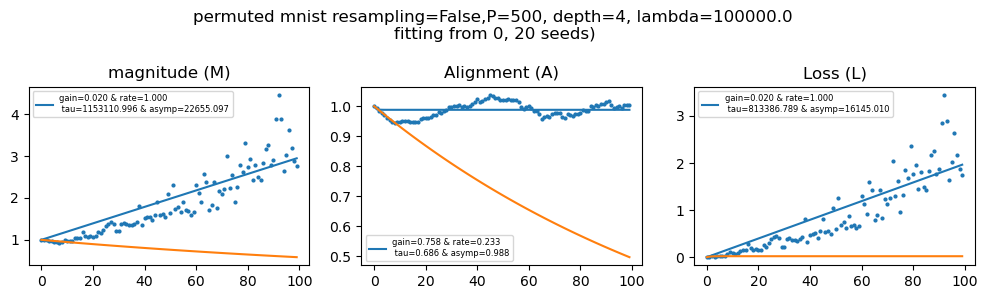

In [13]:
def fit_exp_relax_with_gain(data, gain, fit_to_all=False):
    # assuming the update equation is in the form of x_{t+1} = r x_t + gain. This solves for r from x_{1}, x_{2} with the gain given
    if fit_to_all:
        xaxis = np.arange(len(data))
        p_opt, p_cov = scipy.optimize.curve_fit(lambda t, rate: gain / (1 - rate) + (data[0] - gain / (1 - rate))  * rate**t, xaxis, data, p0=[0.5])
        rate = float(p_opt[0])
        return gain / (1 - rate) + (data[0] - gain / (1 - rate)) * rate**np.arange(len(data)), rate
    else:
        rate = (data[1] - gain) / data[0]
        return gain / (1 - rate) + (data[0] - gain / (1 - rate)) * rate**np.arange(len(data)), rate


def plot_exp_with_rate_and_gain(init_val, length, rate, gain):
    x_axis = np.arange(length)
    plt.plot(x_axis, gain / (1 - rate) + (init_val - gain / (1 - rate)) * rate**x_axis)


def fit_exp_to_first_few(data, num_to_fit=5):
    asymptote, tau, _ = utils.exponential_fit(np.arange(num_to_fit), data[:num_to_fit], p0=[0.5, 20])
    return asymptote + (data[0] - asymptote) * np.exp(-np.arange(len(data)) / tau)


key_value = 4
fitting_from = 0
fit_to_all = False

# print(np.sqrt(organizer.organize_results('tr(P1P2)/P')[key_value].mean(0)))

L1 = all_train_loss[key_value].mean(0)[0][fitting_from:]
M1 = all_train_mag[key_value].mean(0)[0][fitting_from:]
A1 = ((L1 - M1 - 1) * -0.5)

# V_Sigma_V_mean = organizer.organize_results('Vt_Sigma1_Vt')[key_value].mean()
# V1_Sigma_V2_mean = organizer.organize_results('V1_Sigma1_Vt')[key_value].mean()
# V1_V1_mean = organizer.organize_results('V1_V1')[key_value].mean()

fig, axes = plt.subplots(ncols=3, nrows=1, sharex='col', figsize=(10, 3))
axes = axes.ravel()
plt.sca(axes[0])
r_m, gain_m, M_pred = utils.plot_and_exp_fit(M1, fit=True)
M_first_few_fit = fit_exp_to_first_few(M1, num_to_fit=3)
plt.plot(M_first_few_fit)
plt.legend(fontsize=6)
# plt.ylim(0, 1.1)
plt.title('magnitude (M)')

plt.sca(axes[1])
r_a, gain_a, A_pred = utils.plot_and_exp_fit(A1, fit=True)
A_first_few_fit = fit_exp_to_first_few(A1, num_to_fit=3)
plt.plot(A_first_few_fit)

plt.title('Alignment (A)')
# plt.ylim(0, 1.1)
plt.legend(fontsize=6)

plt.sca(axes[2])
r_l, gain_l, _ = utils.plot_and_exp_fit(L1, fit=True)
plt.plot(fit_exp_to_first_few(L1, num_to_fit=3))
# plt.plot(M_pred - 2 * A_pred + 1, 'k--')
# plt.plot(M_first_few_fit - 2 * A_first_few_fit + 1)
plt.legend(fontsize=6)
plt.title('Loss (L)')


plt.suptitle(f'{args.task_type} {args.dataset} resampling={bool(args.resample)},'
              f'P={args.P}, depth={key_value}, lambda={args.lambda_val} \n'
              f'fitting from {fitting_from}, {len(all_train_loss[key_value])} seeds)')
plt.tight_layout()


TypeError: object of type 'NoneType' has no len()

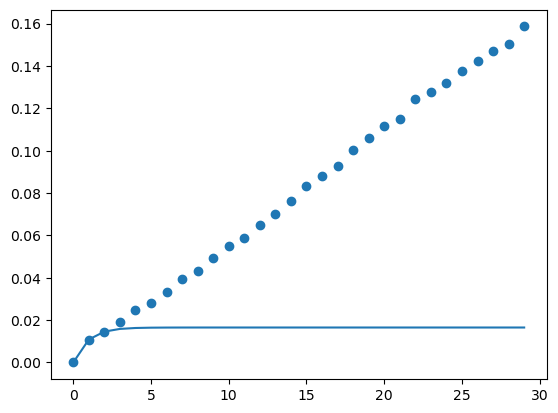

In [448]:
def fit_exp_to_first_few(data, num_to_fit=3, p0=[1, 10]):
    offset, time_constant, _ = utils.exponential_fit(np.arange(num_to_fit), data[:num_to_fit])
    return offset, time_constant, offset + (data[0] - offset) * np.exp(-np.arange(len(data)) / time_constant)

plt.figure()
plt.scatter(range(len(L1)), L1)


## Estimate some OPs from data

In [406]:
depth = 3
nseeds = 100

mean_M_rate = 0
mean_A_rate = 0
a_iP_S1_iP_a = 0

def k_ntk(x1, x2, depth):
    # return theory.arccos_kernel_deep(x1, x2, depth).numpy()
    lamb = 1e5
    w_covar = theory.compute_W_var(1, lamb, 2)
    return theory.cross_kernel_new(x1, x2, 1, 1, w_covar, depth=depth, lamb=lamb, sigma=1)

for seed in tqdm.trange(nseeds):
    torch.manual_seed(seed)
    if args.task_type == 'permuted':
        seq_of_train_x, seq_of_test_x, seq_of_train_y, seq_of_test_y = \
            data.prepare_permuted_dataset(3, args.P, args.P_test, dataset_name=args.dataset,
                                        resample=bool(args.resample),
                                        permutation=args.permutation, data_path=None, precision=64)
    elif args.task_type == 'split':
        seq_of_train_x, seq_of_test_x, seq_of_train_y, seq_of_test_y = \
            data.prepare_split_dataset(args.P, args.P_test, dataset_name=args.dataset,
                                    data_path=None, precision=64, n_tasks=3)
        
    K1 = k_ntk(seq_of_train_x[0], seq_of_train_x[0], depth=depth)
    K2 = k_ntk(seq_of_train_x[1], seq_of_train_x[1], depth=depth)
    # K3 = k_ntk(seq_of_train_x[2], seq_of_train_x[2], depth=depth)
    K12 = k_ntk(seq_of_train_x[0], seq_of_train_x[1], depth=depth)
    K21 = K12.T
    # K13 = k_ntk(seq_of_train_x[0], seq_of_train_x[2], depth=depth)
    # K31 = K13.T
    # K23 = k_ntk(seq_of_train_x[1], seq_of_train_x[2], depth=depth)
    # K32 = K23.T

    Y1 = seq_of_train_y[0]
    Y2 = seq_of_train_y[1]
    # Y3 = seq_of_train_y[2]
    inv_K1 = np.linalg.inv(K1)
    inv_K2 = np.linalg.inv(K2)

    mean_M_rate += (np.linalg.norm(Y2.T @ inv_K2 @ K21)**2 - np.linalg.norm(Y1.T @ inv_K1 @ K12 @ inv_K2 @ K21)**2) / nseeds
    mean_A_rate += ((Y2.T @ inv_K2 @ K21 - Y1.T @ inv_K1 @ K12 @ inv_K2 @ K21) @ Y1) / nseeds
    a_iP_S1_iP_a += (args.P + np.linalg.norm(Y1.T @ inv_K1 @ K12 @ inv_K2 @ K21)**2 - 2 * (Y1.T @ K12 @ inv_K2 @ K21 @ inv_K1 @ Y1)) / nseeds
    # inv_K3 = np.linalg.inv(K3)
    # V2P3S1P3V2 = Y2.T @ inv_K2 @ K23 @ inv_K3 @ K31 @ K13 @ inv_K3 @ K32 @ inv_K2 @ Y2
    # V1P2P3S1P3P2V1 = Y1.T @ inv_K1 @ K12 @ inv_K2 @ K23 @ inv_K3 @ K31 @ K13 @ inv_K3 @ K32 @ inv_K2 @ K21 @ inv_K1 @ Y1
    # V2P3S1P3P2V1 = Y2.T @ inv_K2 @ K23 @ inv_K3 @ K31 @ K13 @ inv_K3 @ K32 @ inv_K2 @ K21 @ inv_K1 @ Y1
    # V2P3S1V2 = Y2.T @ inv_K2 @ K23 @ inv_K3 @ K31 @ K12 @ inv_K2 @ Y2
    # V1P2P3S1P2V1 = Y1.T @ inv_K1 @ K12 @ inv_K2 @ K23 @ inv_K3 @ K31 @ K12 @ inv_K2 @ K21 @ inv_K1 @ Y1
    # V2P3S1P2V1 = Y2.T @ inv_K2 @ K23 @ inv_K3 @ K31 @ K12 @ inv_K2 @ K21 @ inv_K1 @ Y1
    # quad_term = V2P3S1P3V2 + V1P2P3S1P3P2V1 - 2 * V2P3S1P3P2V1
    # cross_term = V2P3S1V2 + V1P2P3S1P2V1 - 2 * V2P3S1P2V1
    # L2 = Y2.T @ inv_K2 @ K21 @ K12 @ inv_K2 @ Y2 + Y1.T @ inv_K1 @ K12 @ inv_K2 @ K21 @ K12 @ inv_K2 @ K21 @ inv_K1 @ Y1 - 2 * Y2.T @ inv_K2 @ K21 @ K12 @ inv_K2 @ K21 @ inv_K1 @ Y1
    # mean_cross_term += cross_term / nseeds
    # mean_quad_term += quad_term / nseeds
    # mean_L2 += L2 / nseeds

# mean_big_quad_term = quad_term - 2 * mean_cross_term

  0%|          | 0/100 [00:00<?, ?it/s]/Users/haozheshan/Dropbox/codes/gp_continual_learning/theory.py:247: UserWarning: arccosine kernel computation is assuming that all inputs have the same norm.
  num_weights = 1
100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


In [407]:
print(mean_A_rate / args.P)
print(mean_M_rate / args.P)
print(a_iP_S1_iP_a / args.P)

tensor([[-0.0200]], dtype=torch.float64)
0.01966296689011189
tensor([[0.9959]], dtype=torch.float64)


In [233]:
mean_L2 / args.P

tensor([[0.0035]], dtype=torch.float64)

In [188]:
print(something_mean)
print(constant_mean)

tensor([[-10.0240]], dtype=torch.float64)
tensor([[1.1249]], dtype=torch.float64)


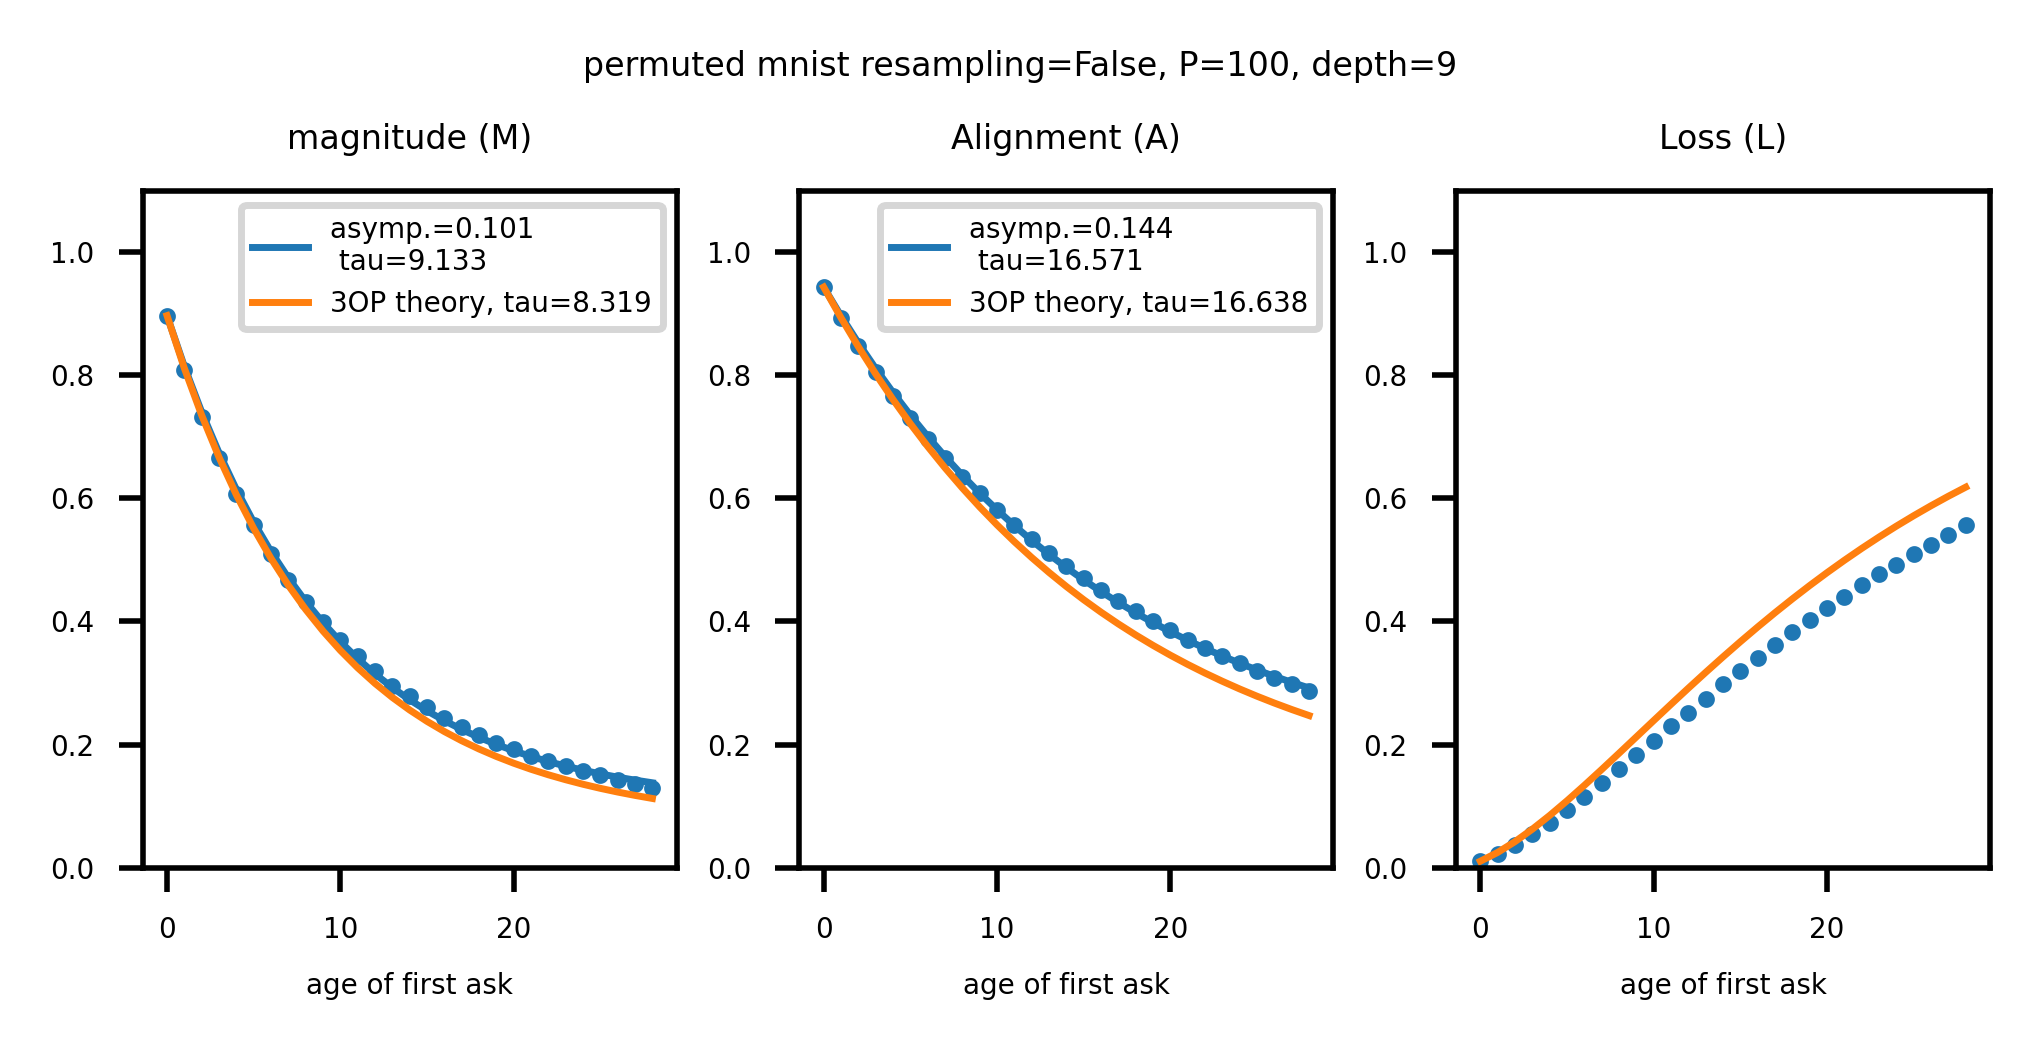

In [246]:

start_ind = 1
A_to_use = A1[start_ind:]
M_to_use = M1[start_ind:]
L_to_use = L1[start_ind:]

T = len(A_to_use)

def fit_exp_relax_with_gain(data, gain):
    # assuming the update equation is in the form of x_{t+1} = r x_t + gain. This solves for r from x_{1}, x_{2} with the gain given
    rate = (data[1] - gain) / data[0]
    return gain / (1 - rate) + (data[0] - gain / (1 - rate)) * rate**np.arange(len(data)), rate

A_theory, fitted_r_a = fit_exp_relax_with_gain(A_to_use, float(V1_Sigma_V2_mean))
tau_fitted = - 1 / np.log(fitted_r_a)
B_theory = fitted_r_a * float(V1_Sigma_V2_mean) * np.exp(-np.arange(T) / tau_fitted)
M_theory = np.zeros_like(A_theory)
M_theory[0] = M_to_use[0]



for i in range(1, T):
    M_theory[i] = fitted_r_a**2 * M_theory[i-1] + float(V_Sigma_V_mean) + 2 * B_theory[i - 1]


# M_theory, fitted_r_m = fit_exp_relax_with_gain(M_to_use, float(V_Sigma_V_mean))

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(4, 2), dpi=500)
plt.sca(axes[0])
utils.plot_and_fit(M_to_use)
plt.plot(M_theory, label=f'3OP theory, tau={-1 / np.log(fitted_r_a**2):.3f}')
plt.ylim(0, 1.1)
plt.xlabel('age of first ask')
plt.legend()
plt.title('magnitude (M)')

plt.sca(axes[1])
utils.plot_and_fit(A_to_use)
plt.plot(A_theory, label=f'3OP theory, tau={-1 / np.log(fitted_r_a):.3f}')
plt.xlabel('age of first ask')
plt.title('Alignment (A)')
plt.ylim(0, 1.1)
plt.legend()

plt.sca(axes[2])
utils.plot_and_fit(L_to_use, fit=False)
plt.xlabel('age of first ask')
plt.title('Loss (L)')
plt.ylim(0, 1.1)
plt.plot(M_theory - 2 * A_theory + 1, color='C1', label='4OP theory')

plt.suptitle(f'{args.task_type} {args.dataset} resampling={bool(args.resample)}, P={args.P}, depth={depth}')
plt.tight_layout()


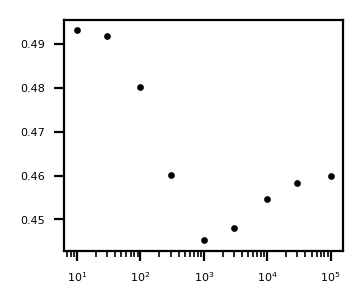

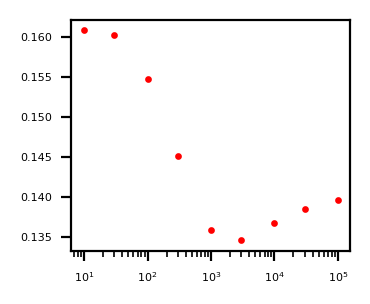

In [59]:
plt.figure()
for key in all_test_loss.keys():
    plt.scatter(float(key), all_test_loss[key].mean(0)[-1, -2], color='k', s=2)
    # plt.scatter(float(key), all_test_loss[key].mean(0)[-2, -2], color='r', s=2)
plt.xscale('log')


plt.figure()
for key in all_test_loss.keys():
    # plt.scatter(float(key), all_test_loss[key].mean(0)[-1, -2], color='k', s=2)
    plt.scatter(float(key), all_test_loss[key].mean(0)[-2, -2], color='r', s=2)
plt.xscale('log')


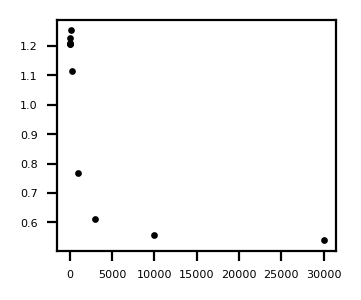

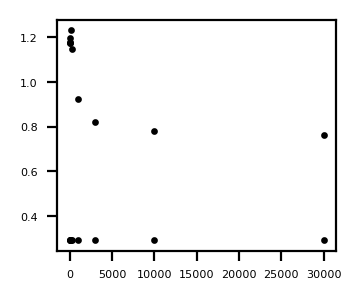

In [3]:
plt.figure()
for key in all_train_loss.keys():
    plt.scatter(float(key), all_train_loss[key].mean(0)[0, -1], color='k', s=2)

plt.figure()
for key in all_test_loss.keys():
    plt.scatter(float(key), all_test_loss[key].mean(0)[0, -1], color='k', s=2)
    plt.scatter(float(key), all_test_loss[key].mean(0)[0, 0], color='k', s=2)



Text(0.5, 1.0, 'gp_10x500_mnist_permuted_diff_depth_50seeds\n 10 layers')

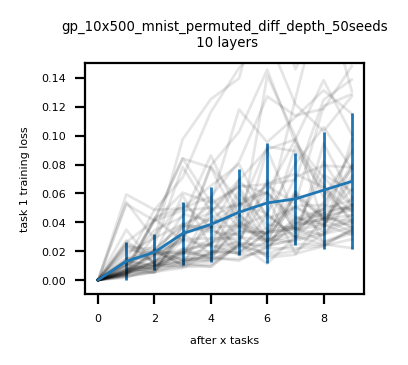

In [7]:
plt.figure()

plt.errorbar(range(10), all_train_loss['10'][:, 0, :].mean(0), all_train_loss['10'][:, 0, :].std(0))
plt.plot(range(10), all_train_loss['10'][:, 0, :].T, color='k', alpha=0.1)
plt.xlabel('after x tasks')
plt.ylabel('task 1 training loss')
plt.ylim(-0.01, 0.15)
plt.title(batch_name + '\n 10 layers')

<ErrorbarContainer object of 3 artists>

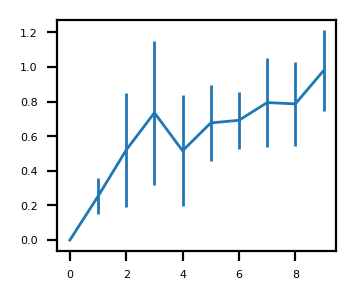

In [11]:
plt.figure()
plt.errorbar(range(10), all_train_loss['1'].mean(0)[0, :], all_train_loss['1'].std(0)[0, :])
# plt.plot(all_train_loss['10'][:, :, 0].T, color='k', alpha=0.3)

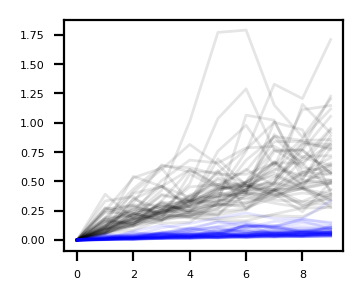

In [11]:
plt.figure()
for key in ['1']:
    plt.plot(all_train_loss[key][:, 0, :].T, color='k', alpha=0.1)

for key in ['10']:
    plt.plot(all_train_loss[key][:, 0, :].T, color='b', alpha=0.1)

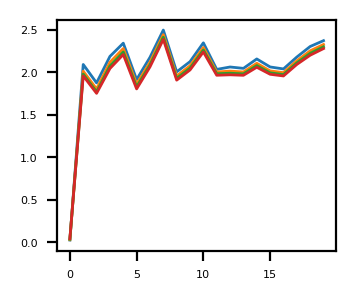

In [4]:
plt.figure()
for key in ['1', '4', '7', '10']:
    plt.plot(all_test_loss[key][:, 0, :].mean(0))

(array([2., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.07836293, 0.17240335, 0.26644377, 0.36048419, 0.45452461,
        0.54856503, 0.64260545, 0.73664587, 0.83068629, 0.92472671,
        1.01876713]),
 <BarContainer object of 10 artists>)

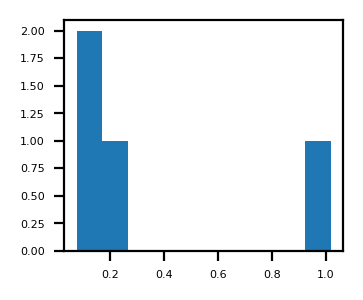

In [4]:
plt.figure()
plt.hist(all_train_loss['100000.0'][:, 0, 1])

In [1]:
[1] * 8

[1, 1, 1, 1, 1, 1, 1, 1]

In [6]:
naive_gen = all_train_loss['1.0'].mean(0)[1, 0]
forgetting = all_train_loss['1.0'].mean(0)[0, 1]

overlap = (naive_gen - forgetting) - 1
rho = 1 - forgetting / 2 / overlap
print(naive_gen)
print(forgetting)
print(overlap)
print(rho)


1.3305295018832242
0.12331165051665695
0.20721785136656723
0.7024589105054484


In [59]:
mean_train_acc_per_key

array([[1.     , 0.8021 , 0.78044, 0.78548, 0.71698],
       [0.50096, 1.     , 0.8354 , 0.74134, 0.73414],
       [0.5327 , 0.51976, 1.     , 0.82216, 0.77484],
       [0.55996, 0.4826 , 0.50622, 1.     , 0.83054],
       [0.48742, 0.48602, 0.49588, 0.5103 , 1.     ]])

# Accumulation: test performance, averaged over tasks, across different params

Text(0, 0.5, 'train acc across time')

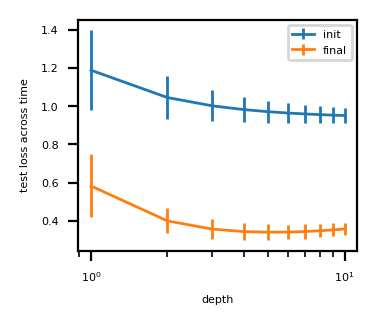

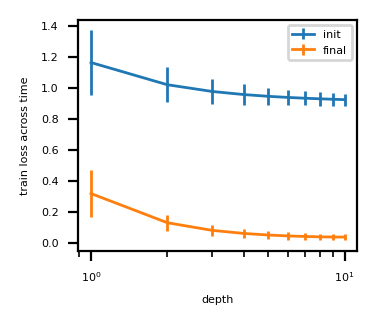

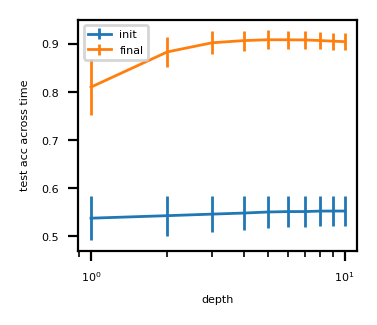

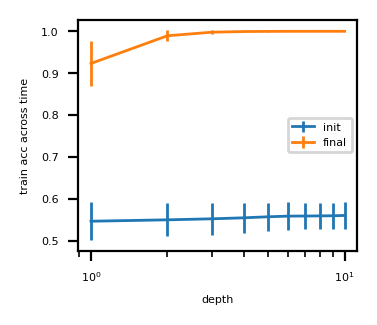

In [55]:
def plot_avg_over_task_across_params(all_xxx):
    plt.figure()
    ticks = []
    task1_mean = []
    task_last_mean = []
    task1_std = []
    task_last_std = []
    for key in all_xxx.keys():
        xxx = all_xxx[key]
        task1_mean.append(xxx.mean(0).mean(0)[0])
        task_last_mean.append(xxx.mean(0).mean(0)[-1])
        task1_std.append(xxx.std(0).mean(0)[0])
        task_last_std.append(xxx.std(0).mean(0)[-1])
        ticks.append(float(key))
    plt.errorbar(ticks, task1_mean, task1_std, label='init')
    plt.errorbar(ticks, task_last_mean, task_last_std, label='final')
    plt.xlabel(sort_by_key)
    plt.xticks(ticks)
    plt.legend()
    plt.xscale('log')

plot_avg_over_task_across_params(all_test_loss)
plt.ylabel('test loss across time')

plot_avg_over_task_across_params(all_train_loss)
plt.ylabel('train loss across time')

plot_avg_over_task_across_params(all_test_acc)
plt.ylabel('test acc across time')

plot_avg_over_task_across_params(all_train_acc)
plt.ylabel('train acc across time')

# Accumulation: test performance, averaged over tasks, plotted across time

Text(0.5, 0.98, 'gp_10x500_mnist_permuted_diff_depth\n performance averaged across tasks')

<Figure size 360x300 with 0 Axes>

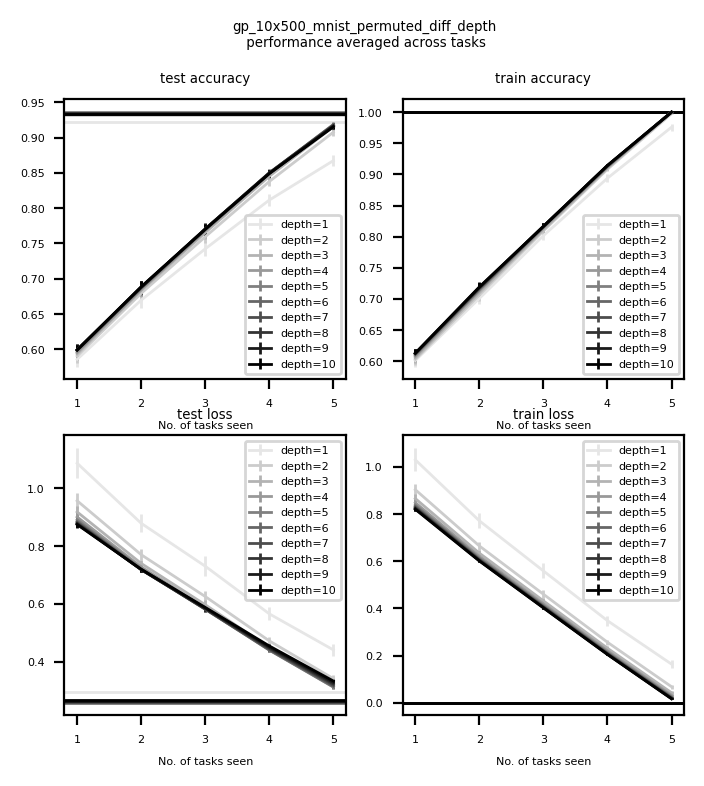

In [56]:
NUM_TASKS = args.n_tasks
plt.figure()

def plot_avg_over_tasks_across_time(all_xxx):

    colors = np.linspace(0, 0.9, len(all_xxx.keys()))[::-1]
    for i, key in enumerate(all_xxx.keys()):
        xxx = all_xxx[key][:, :5, :5]
        plt.errorbar(range(1, 5 + 1), xxx.mean(0).mean(0),
                     xxx.std(0).mean(0) / np.sqrt(xxx.shape[0]), color=str(colors[i]), label=f'{sort_by_key}={key}')
        plt.axhline(xxx.mean(0)[0, 0], color=str(colors[i]))
        plt.legend()
        plt.xlabel('No. of tasks seen')

_, axes = plt.subplots(ncols=2, nrows=2, figsize=(4, 4))
axes = axes.ravel()
plt.sca(axes[0])
plot_avg_over_tasks_across_time(all_test_acc)
plt.title('test accuracy')

plt.sca(axes[1])
plot_avg_over_tasks_across_time(all_train_acc)
plt.title('train accuracy')

plt.sca(axes[2])
plot_avg_over_tasks_across_time(all_test_loss)
plt.title('test loss')

plt.sca(axes[3])
plot_avg_over_tasks_across_time(all_train_loss)
plt.title('train loss')
plt.suptitle(batch_name + '\n performance averaged across tasks')

# forgetting: test performance of first task after all learning, plotted for different params

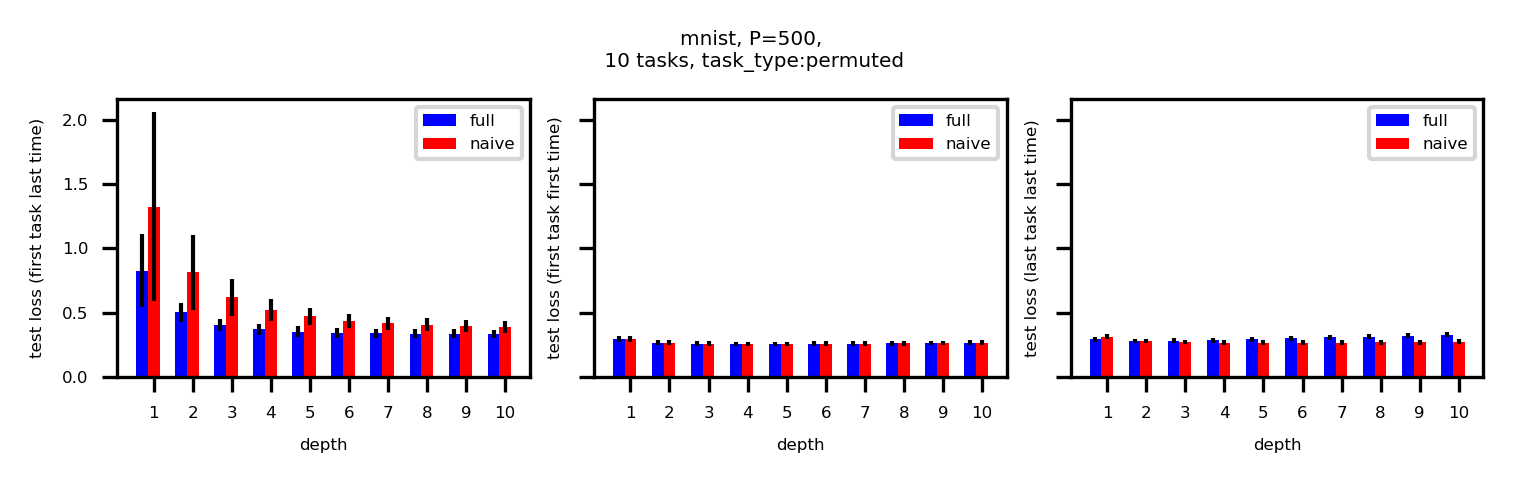

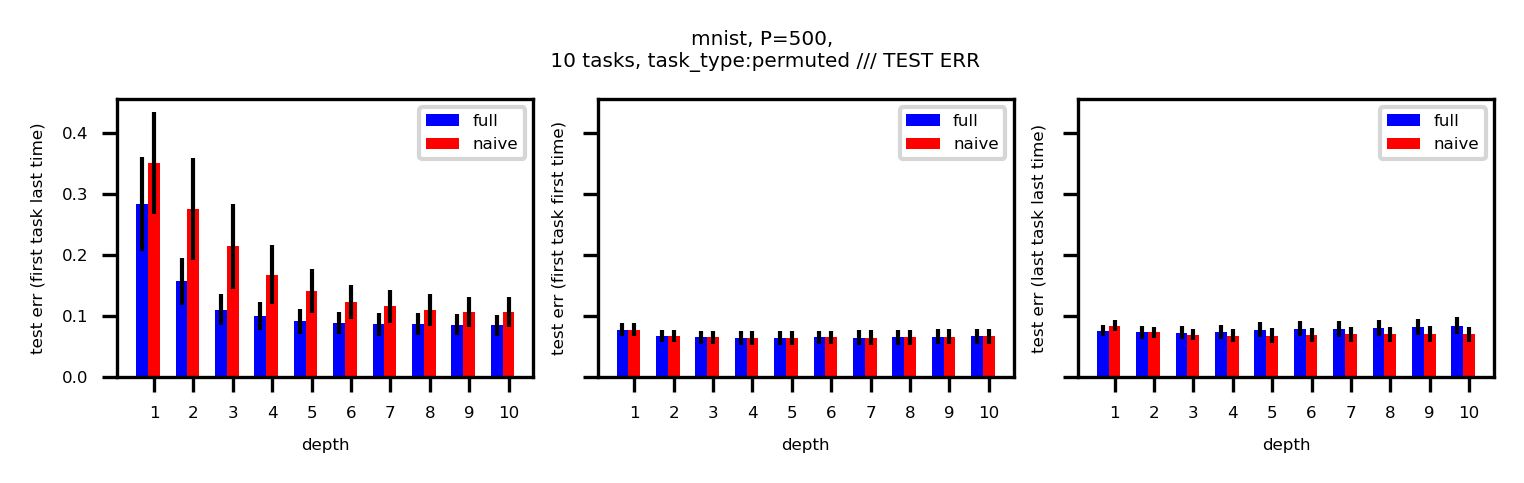

In [58]:
def bar_plot(data_dict, data_dict_naive, bar_width=0.3, bar_space=1, task_ind=0, time_ind=-1):
    tick_loc = []
    tick_text = []
    for i, key in enumerate(data_dict.keys()):
        num_seeds = data_dict[key].shape[0]
        plt.bar(i * bar_space + 1,
                data_dict[key].mean(0)[task_ind, time_ind],
                yerr=data_dict[key].std(0)[task_ind, time_ind], width=bar_width, color='b',
                label='full' if i == 0 else None)
        plt.bar(i * bar_space + 1 + bar_width,
                data_dict_naive[key].mean(0)[task_ind, time_ind],
                yerr=data_dict_naive[key].std(0)[task_ind, time_ind], width=bar_width, color='red',
                label='naive' if i == 0 else None)
        tick_loc.append(i * bar_space + 1 + bar_width)
        tick_text.append(key)
    plt.xticks(tick_loc, tick_text)

_, axes = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(5, 1.5), dpi=300)
axes = axes.ravel()

plt.sca(axes[0])
bar_plot(all_test_loss, all_test_loss_naive)
plt.xlabel(sort_by_key)
plt.ylabel('test loss (first task last time)')
plt.legend()


plt.sca(axes[1])
bar_plot(all_test_loss, all_test_loss_naive, task_ind=0, time_ind=0)
plt.xlabel(sort_by_key)
plt.ylabel('test loss (first task first time)')
plt.legend()


plt.sca(axes[2])
bar_plot(all_test_loss, all_test_loss_naive, task_ind=-1, time_ind=-1)
plt.xlabel(sort_by_key)
plt.ylabel('test loss (last task last time)')
plt.legend()

plt.suptitle(title_text)
plt.tight_layout()


_, axes = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(5, 1.5), dpi=300)
axes = axes.ravel()

plt.sca(axes[0])
bar_plot(all_test_err, all_test_err_naive)
plt.xlabel(sort_by_key)
plt.ylabel('test err (first task last time)')
plt.legend()


plt.sca(axes[1])
bar_plot(all_test_err, all_test_err_naive, task_ind=0, time_ind=0)
plt.xlabel(sort_by_key)
plt.ylabel('test err (first task first time)')
plt.legend()
plt.suptitle(title_text + ' /// TEST LOSS')
plt.tight_layout()

plt.sca(axes[2])
bar_plot(all_test_err, all_test_err_naive, task_ind=-1, time_ind=-1)
plt.xlabel(sort_by_key)
plt.ylabel('test err (last task last time)')
plt.legend()
plt.suptitle(title_text + ' /// TEST ERR')
plt.tight_layout()


# forgetting: test performance of first task, plotted across time

Text(0.5, 0.98, 'gp_5x1000_cifar_split_diff_depth\n performance on first task across time')

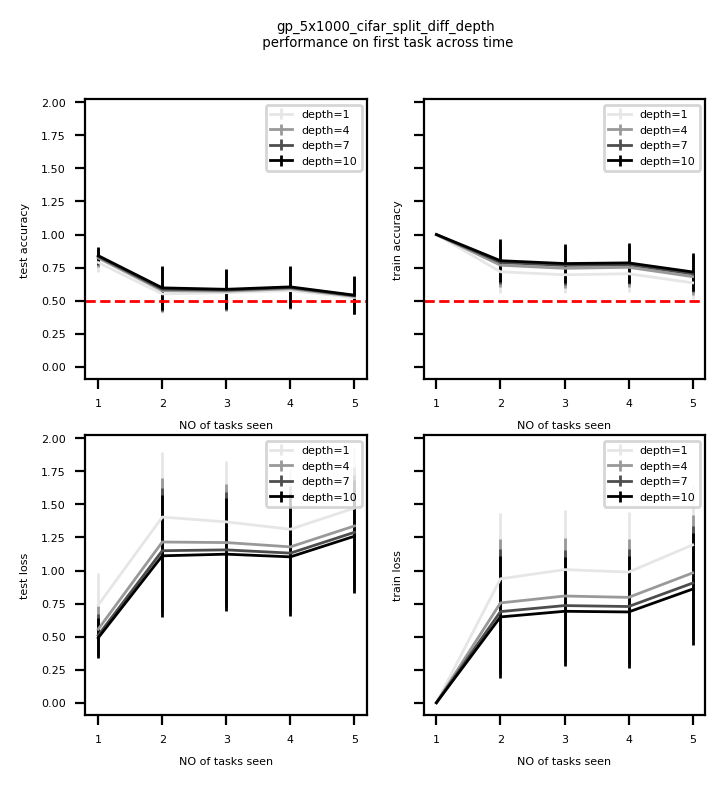

In [68]:
def plot_first_task_across_time(all_xxx):

    colors = np.linspace(0, 0.9, len(all_xxx.keys()))[::-1]
    for i, key in enumerate(all_xxx.keys()):
        xxx = all_xxx[key][:, :5, :5]
        plt.errorbar(range(1, 5 + 1), xxx.mean(0)[0],
                     xxx.std(0)[0],
                     color=str(colors[i]), label=f'{sort_by_key}={key}')
    plt.legend()


_, axes = plt.subplots(ncols=2, nrows=2, figsize=(4, 4), sharey=True)
axes = axes.ravel()
plt.sca(axes[0])
plot_first_task_across_time(all_test_acc)
plt.axhline(0.5, color='r', label='chance', ls='--')
plt.xlabel('NO of tasks seen')
plt.ylabel('test accuracy')

plt.sca(axes[1])
plot_first_task_across_time(all_train_acc)
plt.axhline(0.5, color='r', label='chance', ls='--')
plt.xlabel('NO of tasks seen')
plt.ylabel('train accuracy')
plt.suptitle(batch_name + '\n performance on first task across time')

plt.sca(axes[2])
plot_first_task_across_time(all_test_loss)
plt.xlabel('NO of tasks seen')
plt.ylabel('test loss')
plt.suptitle(batch_name + '\n performance on first task across time')

plt.sca(axes[3])
plot_first_task_across_time(all_train_loss)
plt.xlabel('NO of tasks seen')
plt.ylabel('train loss')
plt.suptitle(batch_name + '\n performance on first task across time')


# plt.figure()
# plot_first_task_across_time(all_test_acc)
# plt.xlabel('NO of tasks seen')
# plt.ylabel('test accuracy')
# plt.title(batch_name)

In [72]:
fNUM_SEEDS = 20
DEPTHS = np.arange(1, 11)

all_scores = np.zeros((NUM_SEEDS, len(DEPTHS)))
all_overlaps = np.zeros((NUM_SEEDS, len(DEPTHS)))
for seed in tqdm.trange(NUM_SEEDS):
    if args.task_type == 'permuted':
        seq_of_train_x, seq_of_test_x, seq_of_train_y, seq_of_test_y = \
            data.prepare_permuted_dataset(args.n_tasks, args.P, args.P_test, dataset_name=args.dataset,
                                            resample=False,
                                            permutation=args.permutation, data_path=None, precision=64)
    elif args.task_type == 'split':
        seq_of_train_x, seq_of_test_x, seq_of_train_y, seq_of_test_y = \
            data.prepare_split_dataset(args.P, args.P_test, dataset_name=args.dataset, data_path=None, precision=64)
    else:
        raise ValueError('task type not understood')

    y = seq_of_train_y[0]
    for i, depth in enumerate(DEPTHS):


        k12 = theory.arccos_kernel_deep(seq_of_train_x[0], seq_of_train_x[1], depth=depth, var1=1)
        k1 = theory.arccos_kernel_deep(seq_of_train_x[0], seq_of_train_x[0], depth=depth, var1=1)
        k2 = theory.arccos_kernel_deep(seq_of_train_x[1], seq_of_train_x[1], depth=depth, var1=1)
        all_scores[seed, i] = torch.norm(k12 @ torch.inverse(k2) @ (torch.eye(seq_of_train_x.shape[1]) - k12.T @ torch.inverse(k1)) @ y)**2 / len(y)
        all_overlaps[seed, i] = torch.mean(k12) / k1[0, 0]

  0%|          | 0/20 [00:00<?, ?it/s]/Users/haozheshan/Dropbox/codes/gp_continual_learning/theory.py:384: UserWarning: arccosine kernel computation is assuming that all inputs have the same norm.
  warnings.warn('arccosine kernel computation is assuming that all inputs have the same norm.')
100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


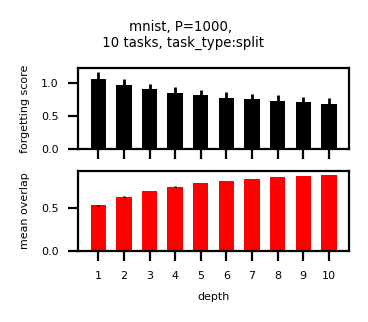

In [73]:
_, axes = plt.subplots(dpi=200, nrows=2, ncols=1, sharex=True)
axes = axes.ravel()

plt.sca(axes[0])
for i, depth in enumerate(np.arange(1, 11)):
    plt.bar(depth, all_scores.mean(0)[i], yerr=all_scores.std(0)[i] / np.sqrt(NUM_SEEDS), color='k', width=0.6)
plt.ylabel('forgetting score')

plt.sca(axes[1])
for i, depth in enumerate(np.arange(1, 11)):
    plt.bar(depth, all_overlaps.mean(0)[i], yerr=all_overlaps.std(0)[i] / np.sqrt(NUM_SEEDS), color='r', width=0.6)
plt.xticks(DEPTHS)
plt.ylabel('mean overlap')
plt.xlabel('depth')
plt.suptitle(title_text)
plt.tight_layout()

Text(0.5, 0, 'score')

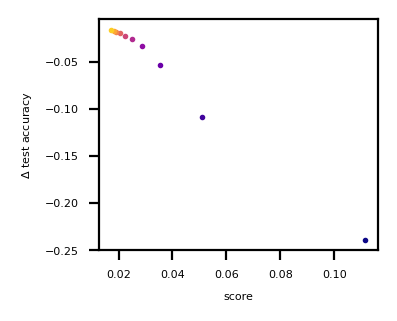

In [41]:
cmap = plt.cm.plasma(np.linspace(0, 0.9, 10))
plt.figure()
for depth in np.arange(1, 11):
    plt.scatter(all_train_loss[str(depth)].mean(0)[0, 1], all_test_acc[str(depth)].mean(0)[0, -1] - all_test_acc[str(depth)].mean(0)[0, 0],
                color=cmap[depth - 1], s=1)
plt.ylabel('$\Delta$ test accuracy')
plt.xlabel('score')
# plt.colorbar(cmap)